In [313]:
import numpy as np
import numpy.linalg as la
from scipy.misc import logsumexp
import scipy.special
def minimum_volume_ellipsoid(points, tol=0.001):
        """
        Finds the ellipse equation in "center form":
        ``(x-c).T * A * (x-c) = 1``.
        """
        N, d = points.shape
        Q = np.column_stack((points, np.ones(N))).T
        err = tol + 1
        u = np.ones(N) / N
        while err > tol:
            # assert(u.sum() == 1) # invariant
            X = np.dot(np.dot(Q, np.diag(u)), Q.T)
            M = np.diag(np.dot(np.dot(Q.T, la.inv(X)), Q))
            jdx = np.argmax(M)
            step_size = (M[jdx] - d - 1) / ((d + 1) * (M[jdx] - 1))
            new_u = (1 - step_size) * u
            new_u[jdx] += step_size
            err = la.norm(new_u - u)
            u = new_u
        c = np.dot(u, points)
        A = la.inv(
            + np.dot(np.dot(points.T, np.diag(u)), points)
            - np.multiply.outer(c, c)
        ) / d
        return A, c

def plot_ellipse(A, c, u):
    """
    Plots a ellipse equation in "center form":
    ``(x-c).T * A * (x-c) = 1``.
    """
    ## find axes lengths
    r = np.sqrt(1 / np.linalg.eigvals(A))
    t = np.linspace(0, 2 * np.pi, 100)
    xt = r[0] * np.cos(t) + c[0]
    yt = r[1] * np.sin(t) + c[1]
    plt.plot(xt, yt)
    plt.scatter(u[:, 0], u[:, 1])
    plt.show()

def ellipse_volume_calculator(A):
    d = A.shape[0]
    r = np.sqrt(1 / np.linalg.eigvals(A))
    return (np.pi**(d / 2.0) / scipy.special.gamma((d / 2.0) + 1)) * np.prod(r)

def enlarge_ellipse_A(enlargement_factor, A):
    return (1 / enlargement_factor) * A

def V_S_calculator(i, N):
    return np.exp(-i / N)

# algorithm 1 various steps
def step_1(u):
    A, c = minimum_volume_ellipsoid(u)
    V_E = ellipse_volume_calculator(A)
    return A, c, V_E

def comparison_enlargement(V_S, V_E, A):
    if V_E > V_S:
        return A
    else:
        enlargement_factor = V_S / V_E
        return enlarge_ellipse_A(enlargement_factor, A)

def step_2(i, N, V_E, A):
    V_S = V_S_calculator(i, N)
    return comparison_enlargement(V_S, V_E, A), V_S

from scipy.cluster.vq import vq, kmeans
def step_3(u):
    centers, assignment = scipy.cluster.vq.kmeans2(u, 2)
    return centers, assignment
def ellipse_find_volume_calculator(a_index, u, assigments):
    points = u[np.where(assignment == a_index)]
    A, c = minimum_volume_ellipsoid(points)
    return A, c, ellipse_volume_calculator(A)
def step_4(assignments, u):
    A_l = [None] * 2
    c_l = [None] * 2
    V_E_l = [None] * 2
    for i in range(0, 2):
        A, c, V_E = ellipse_find_volume_calculator(i, u, assignments)
        A_l[i] = A
        c_l[i] = c
        V_E_l[i] = V_E
    return A_l, c_l, V_E_l
def V_S_k_calculator(n_k, N, V_S):
    return n_k * V_S / N
def step_5(i, assignments, V_E_l, A_l, V_S):
    A_new_l = [None] * 2
    N = len(assignments)
    for i in range(0, 2):
        n = np.sum(assignments == i)
        V_S_k = V_S_k_calculator(n, N, V_S)
        A_new_l[i] = comparison_enlargement(V_S_k, V_E_l[i], A_l[i])
    return A_new_l
# Based on eqn. (16) in the paper but corrected for subtracting the means
def minimum_volume_ellipsoid_fast(points):
    cov = np.cov(np.transpose(points))
    cov_inv = np.linalg.inv(cov)
    c = np.mean(points, axis=0)
    dist = np.zeros(len(points))
    for i in range(len(points)):
        dist[i] = np.matmul(np.matmul(points[i] - c, cov_inv), points[i] - c)
    enlargement_factor = np.max(dist)
    A = (1.0 / enlargement_factor) * cov_inv
    return A, c

Generate 2d points uniformly (in multinest the points must be uniformly distributed in parameter space)

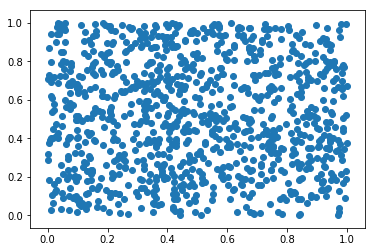

In [318]:
import matplotlib.pyplot as plt
N = 1000
u = np.random.uniform(0, 1, size=(N, 2))
plt.scatter(u[:, 0], u[:, 1])
plt.show()

Calculate minimum volume ellipsoid and plot it

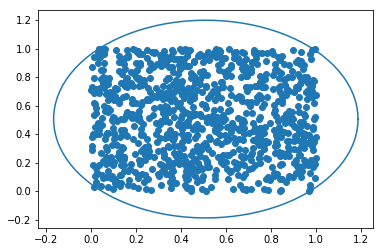

In [319]:
A, c = minimum_volume_ellipsoid(u)
plot_ellipse(A, c, u)

Calculate V(S) - the volume of the space on which the points are distributed which is a function of the iteration $i$

$$V(S) = exp(-i / N),$$

where $N$ is the number of points.

In [255]:
V_S=V_S_calculator(1, N)

Calculate volume of ellipse from its center form which is given by (https://math.stackexchange.com/questions/606184/volume-of-n-dimensional-ellipsoid),

$$V(E) = \frac{\pi^{d/2}}{\Gamma((d/2)+1)} \prod_{i=1}^{d} r_{i}$$,

where $r_i = 1 / \sqrt{\lambda_i}$ are the lengths of the semi axes and $\lambda_i$ are the eigenvalues of the matrix $A$; $d$ is the number of dimensions.

In [91]:
ellipse_volume_calculator(enlarge_ellipse_A(1.1, A)) / ellipse_volume_calculator(A)

1.1000000000000001

In [96]:
ellipse_volume_calculator(step_2(A, 10))

10.000000000000002

In [202]:
centers, assignment = scipy.cluster.vq.kmeans2(u, 2)

In [242]:
A_l, c_l, V_E_l = step_4(assignment, u)

In [264]:
step_5(1, assignment, V_E_l, A_l, V_S)

0.43562192685
0.489687235216
0.5544279069
0.737595709854


[array([[  4.64138268,  -3.00930255],
        [ -3.00930255,  10.81889935]]), array([[ 3.13506587, -1.11721091],
        [-1.11721091,  6.18463359]])]

In [260]:
A_l

[array([[  4.64138268,  -3.00930255],
        [ -3.00930255,  10.81889935]]), array([[ 3.13506587, -1.11721091],
        [-1.11721091,  6.18463359]])]

In [252]:
len(assignment)

100

In [266]:
1+1

2

In [275]:
def empirical_covariance(a_index, assignments, u):
    points = u[np.where(assignments == a_index)]
    cov = np.cov(np.transpose(points))
    return cov

In [276]:
np.linalg.inv(empirical_covariance(0, assignment, u))

array([[ 20.92134055,  -3.52016997],
       [ -3.52016997,  59.75415774]])

In [277]:
points = u[np.where(assignment == 0)]

In [288]:
np.matmul(np.matmul(points[2], np.linalg.inv(empirical_covariance(0, assignment, u))), points[2])

41.249158190519196

In [281]:
assignment

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0])

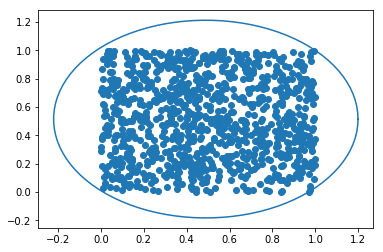

In [320]:
A, c = minimum_volume_ellipsoid_fast(u)
plot_ellipse(A, c, u)

In [307]:
dist = np.zeros(len(u))
for i in range(len(u)):
    dist[i] = np.matmul(np.matmul(u[i] - c, A), u[i] - c)

In [308]:
dist

array([ 0.01050745,  0.31999085,  0.28958673,  0.31276802,  0.08787944,
        0.00854671,  0.35859356,  0.02609308,  0.49900874,  0.54446793,
        0.60523527,  0.76824102,  0.34874113,  0.24564521,  0.91197526,
        0.72167927,  0.60768259,  0.18868421,  0.32193457,  0.64059727,
        0.73655122,  0.08123659,  0.32194049,  0.42717201,  0.36907552,
        0.42888339,  0.00233112,  0.07635721,  0.45159432,  0.67463032,
        0.01402161,  0.16006546,  0.37963888,  0.18436514,  0.66152047,
        0.72980284,  0.05702828,  0.65931139,  0.61331494,  0.45154544,
        0.37026337,  0.02817269,  0.69347191,  0.14423132,  0.36556048,
        0.00189176,  0.14727997,  0.13476607,  0.07182401,  0.22070879,
        0.48307104,  0.49809117,  0.58419041,  0.34690168,  0.22243947,
        0.42277564,  0.56998284,  0.16473297,  0.16814773,  0.98897194,
        0.81689014,  0.13827047,  0.6084455 ,  0.46158804,  0.50730688,
        0.40756919,  0.60060199,  0.05501165,  0.29688372,  0.46